In [521]:
import snap
import pandas as pd
import numpy
import matplotlib.pyplot as plt 
%matplotlib inline

In [316]:
MIN = 60

In [270]:
# Parse tracks file, ignore tracks that has no track id
all_listened = pd.read_csv("dataset\lastfm-dataset-1K\userid-timestamp-artid-artname-traid-traname.tsv", nrows=None, sep='\t', 
                     header=None, names=['user_id', 'timestamp', 'track_id', 'track_name'], 
                     parse_dates=[1], usecols=[0,1,4,5], error_bad_lines=False, warn_bad_lines=True).dropna()

Skipping line 2120260: expected 6 fields, saw 8

Skipping line 2446318: expected 6 fields, saw 8

Skipping line 11141081: expected 6 fields, saw 8

Skipping line 11152099: expected 6 fields, saw 12
Skipping line 11152402: expected 6 fields, saw 8

Skipping line 11882087: expected 6 fields, saw 8

Skipping line 12902539: expected 6 fields, saw 8
Skipping line 12935044: expected 6 fields, saw 8

Skipping line 17589539: expected 6 fields, saw 8



In [271]:
# Extract two weeks data
all_listened_two_weeks = all_listened[(all_listened['timestamp'] >= '2009-04-21 00:00:00') & 
                                      (all_listened['timestamp'] < '2009-05-05 00:00:00')]

In [491]:
# Extract only two days data for all users in the dataset
all_listened = all_listened_two_weeks[(all_listened_two_weeks['timestamp'] >= '2009-04-28 00:00:00') & 
                                      (all_listened_two_weeks['timestamp'] < '2009-05-05 00:00:00')]

In [492]:
# Info about data
all_listened.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73709 entries, 10 to 19080798
Data columns (total 4 columns):
user_id       73709 non-null object
timestamp     73709 non-null datetime64[ns]
track_id      73709 non-null object
track_name    73709 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 2.8+ MB


In [493]:
# Helper dataframe where all listened songs are shifted once so that it can be concatenated
# with the original all_listened dataframe. The resulting dataframe holds rows for all consecutively listen tracks
all_listened_helper = all_listened.rename(columns={'user_id': 'user_id_2', 'timestamp': 'timestamp_2', 
                                                   'track_id': 'track_id_2', 'track_name': 'track_name_2'}).shift()
cons_listened = pd.concat([all_listened, all_listened_helper], axis=1)

In [495]:
# Remove rows for which user id is not the same, tracks are identical 
# or the time difference between two consecutive tracks is bigger than the thredhsold MIN 
cons_listened = cons_listened[(cons_listened['user_id'] == cons_listened['user_id_2']) & 
                              (cons_listened['track_id'] != cons_listened['track_id_2']) &
                              ((cons_listened['timestamp_2']-cons_listened['timestamp']).astype('timedelta64[m]') <= MIN)]

In [497]:
cons_listened[(cons_listened['track_id'] == 'f94fb7e7-76a2-4d84-8734-949f08b0e65b') | 
              (cons_listened['track_id'] == '37f12582-e0aa-4f53-bb2e-d1527e8f2299')]

,user_id,timestamp,track_id,track_name,user_id_2,timestamp_2,track_id_2,track_name_2
14255172,user_000761,2009-04-29 20:21:35,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat,user_000761,2009-04-29 20:25:19,3e85a4cc-3733-4160-8982-6fa6da51cfbc,Primrose Path
16060176,user_000833,2009-05-04 06:47:31,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat,user_000833,2009-05-04 06:47:55,6f71016e-8be0-4f9c-b72a-f88cc8347d3c,"Endlessly, She Said"
16060177,user_000833,2009-05-04 06:43:45,f94fb7e7-76a2-4d84-8734-949f08b0e65b,Saw You Drown,user_000833,2009-05-04 06:47:31,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat
16060178,user_000833,2009-05-04 06:43:45,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat,user_000833,2009-05-04 06:43:45,f94fb7e7-76a2-4d84-8734-949f08b0e65b,Saw You Drown
16060179,user_000833,2009-05-04 06:38:43,f94fb7e7-76a2-4d84-8734-949f08b0e65b,Saw You Drown,user_000833,2009-05-04 06:43:45,37f12582-e0aa-4f53-bb2e-d1527e8f2299,Sweat


In [498]:
def cons_group(track_1_id, track_2_id):
    """ Function to determine the group based on two tracks presented in the row. """
    if track_1_id > track_2_id:
        return track_1_id, track_2_id
    else:
        return track_2_id, track_1_id

# Count how many times each two tracks were played one after other in MIN minutes period 
cons_listened_counts = pd.DataFrame({'cons_count' : cons_listened.groupby(
            numpy.vectorize(cons_group)(cons_listened['track_id'], cons_listened['track_id_2'])
        ).size()}).reset_index()

cons_listened_counts

In [500]:
# Count how many times each song were played in total
track_counts = all_listened.groupby(['track_id', 'track_name']).size()

In [502]:
# Create a tracks map where each track id -> track name, track total count, integer id
tracks_map = {}
for i, (track_id, track_name) in enumerate(track_counts.keys()):
    tracks_map[track_id] = {'track_name': track_name, 'track_count': track_counts[(track_id, track_name)], 'int_id': i} 
    
tracks_map

In [504]:
def similarity(cons_count, track_1_count, track_2_count):
    """ Function to calculate the similarity between two songs
        given both tracks total counts in the corpus and the 
        number of times both tracks were played one after other"""
    return cons_count*1.0/numpy.sqrt(tracks_map[track_1_count]['track_count']*tracks_map[track_2_count]['track_count'])

# Add similarity column that determines the similarity between two tracks in the row calculated using similarity function
cons_listened_counts['similarity'] = numpy.vectorize(similarity)(cons_listened_counts['cons_count'], 
                                                                 cons_listened_counts['level_0'], 
                                                                 cons_listened_counts['level_1'])

cons_listened_counts

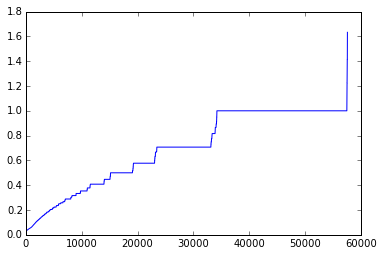

In [531]:
# Plot the similarities between songs in increasing order
plt.plot(cons_listened_counts['similarity'].sort(inplace=False))

In [508]:
# Create song network, add all tracks as nodes in it 
song_network = snap.TUNGraph.New()
labels = {}
for track_id in tracks_map:
    int_id = tracks_map[track_id]['int_id']
    song_network.AddNode(int_id)
    labels[int_id] = tracks_map[track_id]['track_name']

# Only keep the similar tracks and add edges between these tracks in the network specified above
similar_songs = cons_listened_counts[cons_listened_counts['similarity'] > 0.4].values

for similar in similar_songs:
    song_network.AddEdge(tracks_map[similar[0]]['int_id'], tracks_map[similar[1]]['int_id'])
    
print song_network.GetEdges()

In [435]:
import networkx as nx
g = nx.Graph()
for similar in similar_songs:
    g.add_edge(tracks_map[similar[0]]['int_id'], tracks_map[similar[1]]['int_id'])
nx.draw_networkx(g)

In [514]:
# Cluster the tracks network using Clauset-Newman-Moore community detection method
CmtyV = snap.TCnComV()
modularity = snap.CommunityCNM(song_network, CmtyV)
print "The modularity of the network is %f" % modularity

The modularity of the network is 0.943812


In [515]:
len(CmtyV)

2112

In [516]:
l = [len(a) for a in CmtyV]

In [518]:
l.sort()
l[-10:]

[422, 445, 496, 522, 579, 582, 583, 610, 804, 1050]

In [519]:
s = [a for a in CmtyV if len(a) == 5]

In [520]:
for a in s[0]:
    print labels[a]

Cowgirl
Destined For Great Things
Another Rather Lovely Thing
What Must Be Done
Song For Jesse
